##Импорт библиотек и загрузка данных

In [ ]:
# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
#df = pd.read_csv("data_with_coords_21_10_2023.csv", sep =',')
#df = pd.read_csv("updated_data_with_coords_22_10_2023.csv", sep=",")

df = pd.read_csv("train_with_district_region.csv", sep=",")

In [ ]:
df.shape

(6261, 58)

In [ ]:
df = df[df[['locality_area','locality_population','city','lat','bank']].notnull().all(axis=1)]

In [ ]:
df.drop(['city_area', 'city_district','address', 'address_rus','metro','Unnamed: 0','id'], axis=1, inplace=True)

In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.shape

(6029, 51)

## Загрузка библиотек и данных

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import Pool
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier
from category_encoders.target_encoder import TargetEncoder # счетчики+сглаживание

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


import shap

random.seed(42)
np.random.seed(42)

Работа с банкоматами

In [ ]:
df['atm_group'].value_counts()

5478.0    2575
1942.0    1100
8083.0    1013
496.5      590
3185.5     573
1022.0     135
32.0        43
Name: atm_group, dtype: int64

In [ ]:
df['atm_group'] = df['atm_group'].replace({8083.0: 'Rosbank',
                                                       1022.0: 'AkBars',
                                                       1942.0: 'Alfabank',
                                                       3185.5: 'Gazprombank',
                                                       32.0: 'Raiffeisen',
                                                       496.5: 'Rosselkhozbank',
                                                       5478.0: 'Uralsib'})

## Вынесенные методы

In [ ]:
def one_hot_encode_drop_first(X_train, X_test, cols):
      drop_enc = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train[cols])

      X_train_enc = pd.DataFrame(drop_enc.transform(X_train[cols]).toarray(),
                                columns=drop_enc.get_feature_names_out(cols),
                                dtype=int)
      X_test_enc = pd.DataFrame(drop_enc.transform(X_test[cols]).toarray(),
                                columns=drop_enc.get_feature_names_out(cols),
                                dtype=int)

      X_train_enc = X_train_enc.reset_index(drop=True)
      X_test_enc = X_test_enc.reset_index(drop=True)
      X_train = X_train.reset_index(drop=True)
      X_test = X_test.reset_index(drop=True)

      X_train_enc = pd.concat([X_train.drop(columns=cols), X_train_enc], axis=1)
      X_test_enc = pd.concat([X_test.drop(columns=cols), X_test_enc], axis=1)

      return X_train_enc, X_test_enc, drop_enc


In [ ]:
def target_mean_encoder(X_train, X_test, cols):
    tgt_enc = TargetEncoder(cols=cols)
    Xtrain_new = tgt_enc.fit_transform(X_train,y_train)
    Xtest_new = tgt_enc.transform(X_test)
    return Xtrain_new, Xtest_new, tgt_enc

In [ ]:
def regression(model, X_train, X_test, y_train, y_test, features):
    # Создаем модель линейной регрессии
    #model = Lasso()

    # Обучаем модель на тренировочных данных
    model.fit(X_train, y_train)

    # Предсказываем значения для тренировочного и тестового набора данных
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
    mse_train = MSE(y_train, pred_train)
    mse_test = MSE(y_test, pred_test)

     # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))


    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)



    print(f'MSE для трейна равно {mse_train:.4f}')
    print(f'MSE для теста равно {mse_test:.4f}')

    print(f'RMSE для трейна равно {rmse_train:.4f}')
    print(f'RMSE для теста равно {rmse_test:.4f}')

    print(f'r2 для трейна равно {r2_train:.10f}')
    print(f'r2 для теста равно {r2_test:.10f}')

    weights = abs(model.coef_)

    return mse_train, mse_test, r2_train, r2_test, weights

In [ ]:
def get_weights(features, weights):
  feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
  feature_weights.sort_values(by='Weight', ascending=False)
  return feature_weights

In [ ]:
  def scale_data(X_train, X_test):
    X_train_sc = X_train.copy()
    X_test_sc = X_test.copy()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    return  X_train_sc, X_test_sc, scaler

In [ ]:
  def scale_data_cols(X_train, X_test, cols):
    X_train_sc = X_train_enc.copy()
    X_test_sc = X_test_enc.copy()
    scaler = StandardScaler()
    scaler.fit(X_train_enc[cols])
    X_train_sc[cols] = scaler.transform(X_train_enc[cols])
    X_test_sc[cols] = scaler.transform(X_test_enc[cols])
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_enc.columns)
    return  X_train_sc, X_test_sc, scaler

In [ ]:
def grid_search(model,params,cv,scoring,X_train,X_test, y_train, y_test):

  # первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика
  gs = GridSearchCV(model, params, cv=cv, scoring=scoring)

  gs.fit(X_train, y_train) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

  #print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
  print(gs.best_params_) # оптимальные гиперпараметры

  pred_train = gs.best_estimator_.predict(X_train)
  pred_test = gs.best_estimator_.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  weights = abs(gs.best_estimator_.coef_)

  return mse_train, mse_test, r2_train, r2_test, weights, gs.best_estimator_


In [ ]:
def grid_decision_tree(param_grid, cv, X_train, y_train, X_test, y_test):

  # Create an instance of DecisionTreeRegressor
  dt = DecisionTreeRegressor()

  # Create the GridSearchCV object
  grid_search = GridSearchCV(dt, param_grid, cv=cv)

  # Perform grid search to find the optimal hyperparameters
  grid_search.fit(X_train, y_train)

  # Print the optimal hyperparameters
  print("Optimal hyperparameters:", grid_search.best_params_)

  # Get the best decision tree model
  best_tree = grid_search.best_estimator_
  pred_train = best_tree.predict(X_train)
  pred_test = best_tree.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test, best_tree

In [ ]:
def grid_random_forest(param_grid, cv, X_train, y_train, X_test, y_test):
  # Define the parameter grid
  param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5]
  }

  # Create an instance of RandomForestRegressor
  rf = RandomForestRegressor()

  # Create the GridSearchCV object
  grid_search = GridSearchCV(rf, param_grid, cv=5)

  # Perform grid search to find the optimal hyperparameters
  grid_search.fit(X_train, y_train)

  # Print the optimal hyperparameters
  print("Optimal hyperparameters:", grid_search.best_params_)

  # Get the best random forest model
  best_rf = grid_search.best_estimator_
  pred_train = best_rf.predict(X_train)
  pred_test = best_rf.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test, best_rf

In [ ]:
def cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices):

  # Создаем модель CatBoostRegressor
  model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

  model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Verbose',
  #    plot=True
  )

  # Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  # Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

  # Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

# Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test, model

In [ ]:
def grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test):

# Задаем сетку параметров для перебора

# Создаем модель CatBoostRegressor
  model = CatBoostRegressor(iterations=2, loss_function=loss)

# Создаем объект GridSearchCV для перебора параметров
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)

# Обучаем модель с использованием поиска по сетке
  grid_search.fit(X_train, y_train, cat_features=categorical_features_indices)

# Получаем лучшие параметры из поиска
  best_params = grid_search.best_params_

# Создаем модель с лучшими параметрами
  model = CatBoostRegressor(**best_params)

# Обучаем модель на тренировочных данных
  model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  #weights = abs(grid_search.best_estimator_.coef_)

  return mse_train, mse_test, r2_train, r2_test, model

In [ ]:
def pool_cat_boost(X_train, X_test):

  # Создаем модель CatBoostRegressor
  params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}

  model = CatBoostRegressor(**params)
  model.fit(X_train, y_train, categorical_features_indices)
  cv_dataset = Pool(data=X_train,
                  label=y_train,
                   cat_features=categorical_features_indices)
  scores = cv(cv_dataset,
            params,
            fold_count=5,
            plot="True")

  # Предсказываем значения для тренировочного и тестового набора данных
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  # Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  # Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  # Выводим значения MSE и r2 для тренировочного и тестового набора данных
  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test

In [ ]:
def weights_plot(coefs, columns, count, name_model):
  indices = np.argsort(np.abs(coefs))[::-1][:count][::-1]  # Индексы первых 10 наиболее важных признаков

  plt.figure(figsize=(7, 7))
  plt.barh(range(10), np.abs(coefs[indices]))
  plt.yticks(range(10), columns[indices])
  plt.xlabel("Важность")
  plt.ylabel("Признаки")
  plt.title(f"Первые {count} признаков ( по важности, {name_model})")
  plt.show()


In [ ]:
def shap_plot(model, X_train_sample, count):
  explainer = shap.Explainer(model, X_train_sample)
  shap_values = explainer(X_train_sample)
  shap.summary_plot(shap_values, X_train_sample, max_display = count)

In [ ]:

X = df.drop(columns=['target', 'oktmo'])
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

df = X_train.copy()

with open("Imputer.pickle", "rb") as f:
    imp = pickle.load(f)
    cols = df.columns
    df = imp.transform(df)
    print(df.shape)

with open("Encoder.pickle", "rb") as f:
     enc = pickle.load(f)
     cols = ['atm_group','federal_district', 'region_with_type']
     df_enc = pd.DataFrame(enc.transform(df[cols]).toarray(),
                                columns=enc.get_feature_names_out(cols),
                                dtype=int)

     df_enc = df_enc.reset_index(drop=True)
     df_enc = pd.concat([df.drop(columns=cols), df_enc], axis=1)


with open("Scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
    df = scaler.transform(df)
    df_sc = pd.DataFrame( scaler.transform(df), columns=df.columns)

with open("Model.pickle", "rb") as f:
    model = pickle.load(f)
    pred = model.predict(df_sc)

NameError: name 'df' is not defined

## Линейные модели без категориального признака city

### Разбивка на трейн и тест

In [ ]:
Y = df['target']
X = df.drop(columns=['target', 'oktmo'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
X_train.columns

Index(['atm_group', 'lat', 'long', 'city', 'federal_district',
       'region_with_type', 'locality_area', 'locality_population',
       'sustenance', 'education', 'fuel', 'car_service', 'parking_space',
       'atm', 'bank', 'bureau_de_change', 'outpatient_medical_facilities',
       'inplace_medical_facilities', 'pharmacy', 'veterinary', 'entertainment',
       'entertainment_for_adults', 'administrative_buildings', 'police',
       'fire_station', 'post_office', 'grave_yard', 'marketplace', 'monastery',
       'place_of_worship', 'public_transport_stop_position', 'alcohol_shop',
       'food_shop', 'supermarket', 'mall', 'wholesale', 'clothing_shop',
       'discount_store', 'beauty_store', 'hardware_store', 'interior_store',
       'electronics_store', 'sport_store', 'auto_moto_store',
       'car_parts_store', 'hobbies_store', 'books_store', 'hotel', 'museum'],
      dtype='object')

In [ ]:
X_train.shape

(4220, 49)

### Заполнение пропусков

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
cols = X_train.columns

imp.fit(X_train)
X_train[cols] = imp.transform(X_train)
X_test[cols] = imp.transform(X_test)

import pickle

# Сохранение объекта SimpleImputee в файл для дальнейшего использования в сервисе FastApi
with open("Imputer.pickle", "wb") as f:
    pickle.dump(imp, f)

In [ ]:
X_train.columns

Index(['atm_group', 'lat', 'long', 'city', 'federal_district',
       'region_with_type', 'locality_area', 'locality_population',
       'sustenance', 'education', 'fuel', 'car_service', 'parking_space',
       'atm', 'bank', 'bureau_de_change', 'outpatient_medical_facilities',
       'inplace_medical_facilities', 'pharmacy', 'veterinary', 'entertainment',
       'entertainment_for_adults', 'administrative_buildings', 'police',
       'fire_station', 'post_office', 'grave_yard', 'marketplace', 'monastery',
       'place_of_worship', 'public_transport_stop_position', 'alcohol_shop',
       'food_shop', 'supermarket', 'mall', 'wholesale', 'clothing_shop',
       'discount_store', 'beauty_store', 'hardware_store', 'interior_store',
       'electronics_store', 'sport_store', 'auto_moto_store',
       'car_parts_store', 'hobbies_store', 'books_store', 'hotel', 'museum'],
      dtype='object')

### Кодирование категориальных признаков

In [ ]:
X_train_mean, X_test_mean, target_encoder = target_mean_encoder(X_train, X_test, ['atm_group','federal_district', 'region_with_type'])

In [ ]:
cols = ['atm_group','federal_district', 'city','region_with_type']
X_train_enc, X_test_enc, encoder = one_hot_encode_drop_first(X_train, X_test, cols)

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


In [ ]:
import pickle

# Сохранение объекта SimpleImputee в файл для дальнейшего использования в сервисе FastApi
with open("Encoder.pickle", "wb") as f:
    pickle.dump(encoder, f)

In [ ]:
a,b,c,d, weights = regression(LinearRegression(),X_train_enc, X_test_enc, y_train, y_test, X_train_enc.columns)

MSE для трейна равно 0.0016
MSE для теста равно 528730.7805
RMSE для трейна равно 0.0403
RMSE для теста равно 727.1388
r2 для трейна равно 0.7830010215
r2 для теста равно -73982794.1474056244


### Без масштабирования - Линейная регрессия

### Масштабирование

In [ ]:
X_train_sc, X_test_sc, scaler = scale_data(X_train_enc, X_test_enc)

In [ ]:
import pickle

# Сохранение объекта SimpleImputee в файл для дальнейшего использования в сервисе FastApi
with open("Scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
import pickle

# Load the scaler object from the pickle file
with open("Scaler.pickle", "rb") as f:
    scaler_new = pickle.load(f)

In [ ]:
X_train_mean_sc, X_test_mean_sc, scaler = scale_data(X_train_mean, X_test_mean)

### С маштабированием - линейная регрессия

In [ ]:
a,b,c,d, weights = regression(LinearRegression(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0449
RMSE для теста равно 0.0469
r2 для трейна равно 0.7303915714
r2 для теста равно 0.6915782715


In [ ]:
a,b,c,d, weights = regression(LinearRegression(),X_train_mean_sc, X_test_mean_sc, y_train, y_test, X_train_mean_sc.columns)

MSE для трейна равно 0.0021
MSE для теста равно 0.0022
RMSE для трейна равно 0.0462
RMSE для теста равно 0.0472
r2 для трейна равно 0.7143961607
r2 для теста равно 0.6887075121


### DecisionTreeRegressor

In [ ]:
param_grid = {'max_depth': range(2, 16),
              'max_features': range(5, 16)}

cv = 5
a,b,c,d,model = grid_decision_tree(param_grid, cv, X_train_sc, y_train, X_test_sc, y_test)

Optimal hyperparameters: {'max_depth': 9, 'max_features': 11}
MSE для трейна равно 0.0028
MSE для теста равно 0.0035
RMSE для трейна равно 0.0528
RMSE для теста равно 0.0593
r2 для трейна равно 0.6267903446
r2 для теста равно 0.5084065533


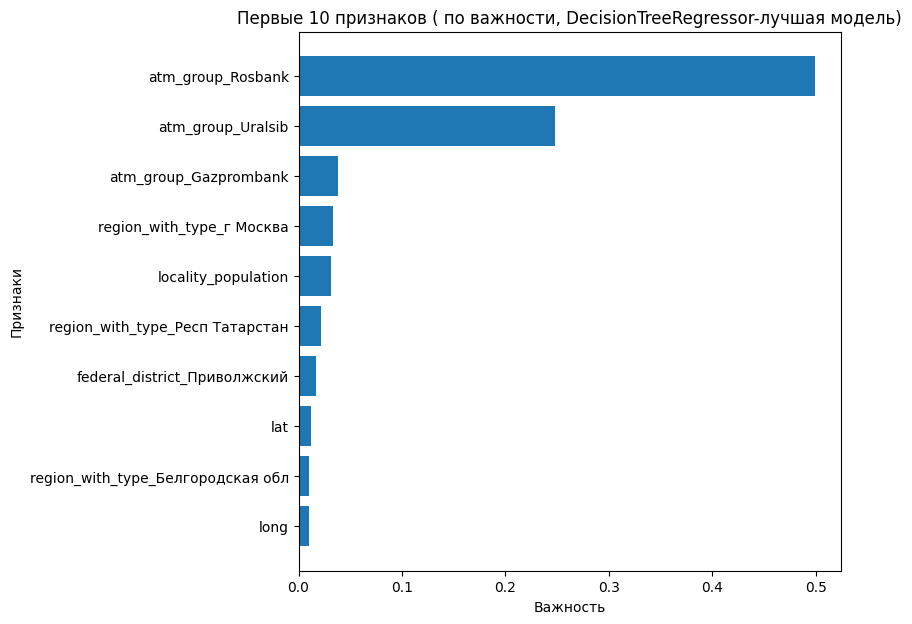

In [ ]:
weights_plot(model.feature_importances_, X_train_sc.columns, 10, "DecisionTreeRegressor-лучшая модель")

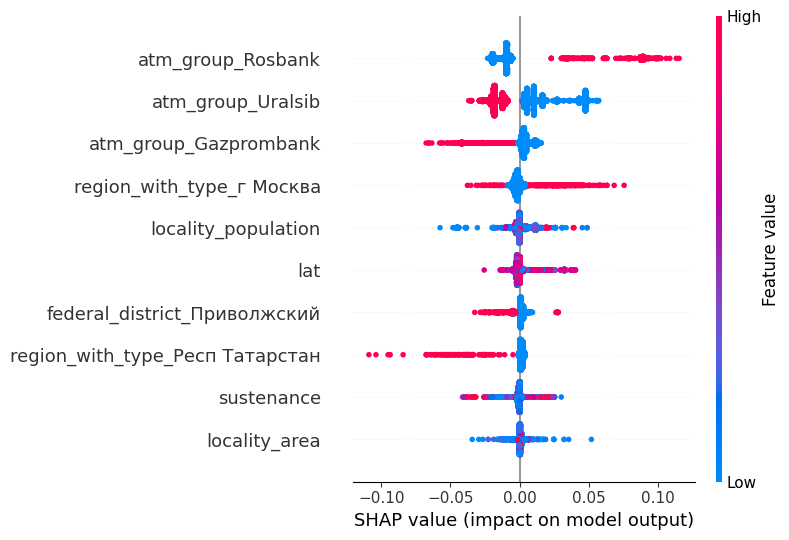

In [ ]:
shap_plot(model, X_train_sc, 10)

### RandomForest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5]
}
a,b,c,d,model = grid_random_forest(param_grid, cv, X_train_sc, y_train, X_test_sc, y_test)

Optimal hyperparameters: {'max_depth': None, 'n_estimators': 200}
MSE для трейна равно 0.0003
MSE для теста равно 0.0020
RMSE для трейна равно 0.0181
RMSE для теста равно 0.0442
r2 для трейна равно 0.9558898513
r2 для теста равно 0.7261497832


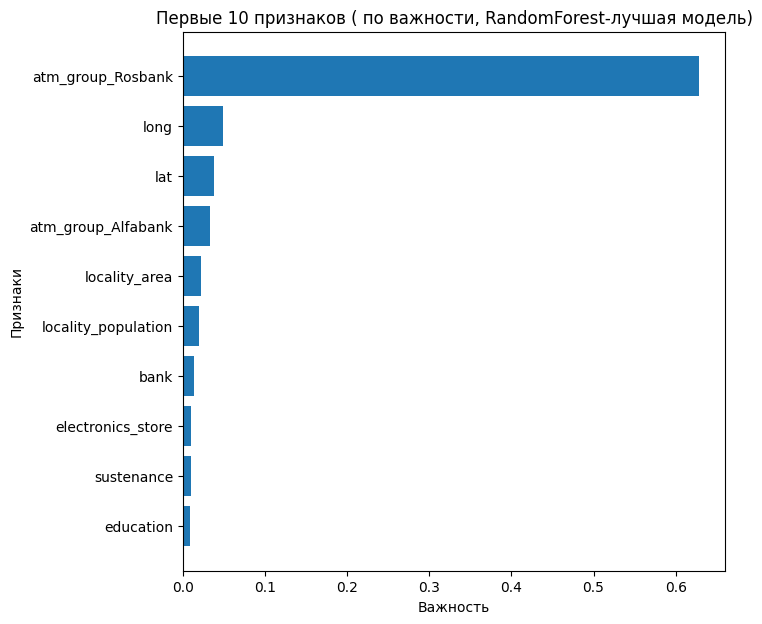

In [ ]:
weights_plot(model.feature_importances_, X_train_sc.columns, 10, "RandomForest-лучшая модель")

In [ ]:
X_train_sc_1000 = X_train_sc.sample(1000)

In [ ]:
explainer = shap.Explainer(model, X_train_sc_1000)
shap_values = explainer(X_train_sc_1000)

 97%|=================== | 97/100 [00:21<00:00]       

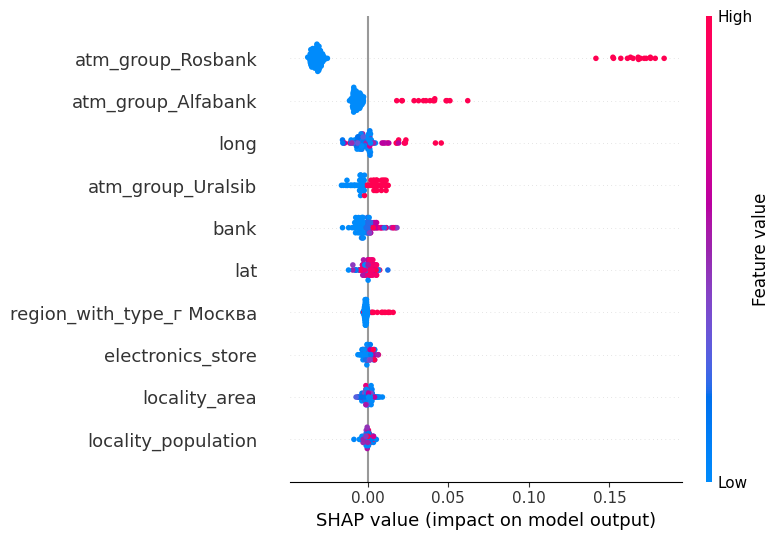

In [ ]:
shap.summary_plot(shap_values, X_train_sc_100, max_display = 10)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5]
}
cv=5
a,b,c,d,model = grid_random_forest(param_grid, cv, X_train_mean_sc, y_train, X_test_mean_sc, y_test)

Optimal hyperparameters: {'max_depth': None, 'n_estimators': 200}
MSE для трейна равно 0.0003
MSE для теста равно 0.0019
RMSE для трейна равно 0.0180
RMSE для теста равно 0.0440
r2 для трейна равно 0.9563723426
r2 для теста равно 0.7291096111


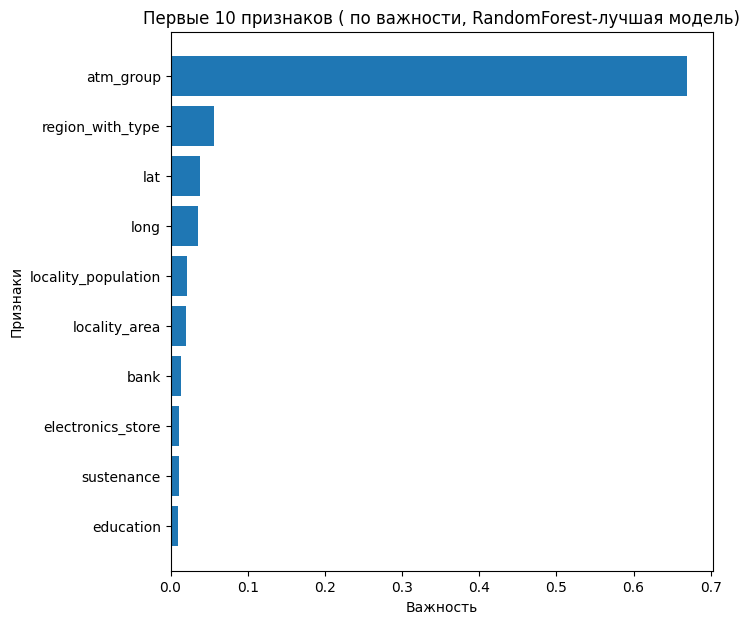

In [ ]:
weights_plot(model.feature_importances_, X_train_mean_sc.columns, 10, "RandomForest-лучшая модель")

In [ ]:
X_train_mean_sc_1000 = X_train_mean_sc.sample(1000)

In [ ]:
explainer = shap.TreeExplainer(model, X_train_mean_sc_1000)
shap_values = explainer(X_train_mean_sc_1000)

100%|===================| 997/1000 [03:04<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -0.048625, while the model output was -0.047232. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
shap.summary_plot(shap_values, X_train_mean_sc_100, max_display = 10)

### Lasso

In [ ]:
a,b,c,d, weights = regression(Lasso(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0071
RMSE для трейна равно 0.0864
RMSE для теста равно 0.0845
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0001186011


In [ ]:
a,b,c,d, weights = regression(Lasso(),X_train_mean_sc, X_test_mean_sc, y_train, y_test, X_train_mean_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0071
RMSE для трейна равно 0.0864
RMSE для теста равно 0.0845
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0001186011


### Lasso - подбор оптимальных гиперпараметров

### OHE

In [ ]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d,weights, best_lasso = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

{'alpha': 0.0001}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0449
RMSE для теста равно 0.0468
r2 для трейна равно 0.7297036286
r2 для теста равно 0.6930046575


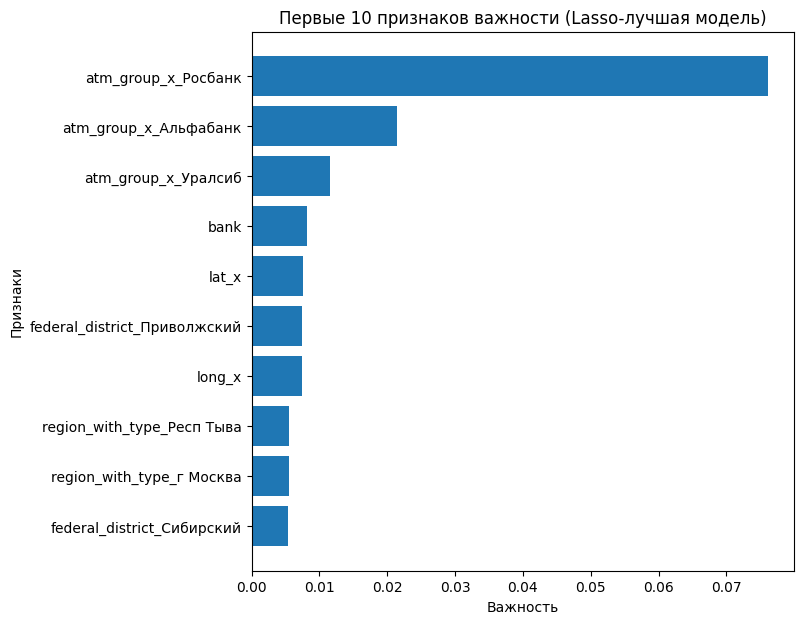

In [ ]:
weights_plot(weights, X_train_sc.columns, 10, "Lasso-лучшая модель")

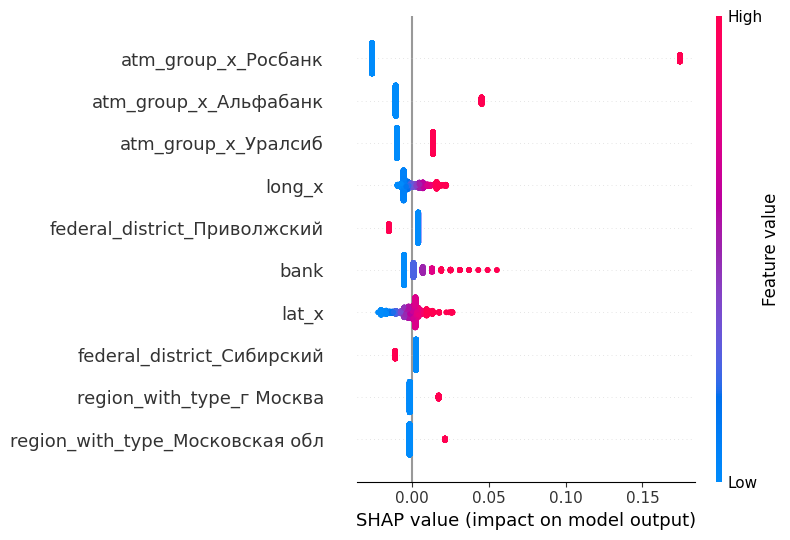

In [ ]:
shap_plot(best_lasso, X_train_sc, 10)

In [ ]:
import pickle

# Сохранение объекта SimpleImputee в файл для дальнейшего использования в сервисе FastApi
with open("Lasso.pickle", "wb") as f:
    pickle.dump(best_lasso, f)

### TargetMean

In [ ]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d,weights, best_lasso_mean = grid_search(Lasso(),params,cv,scoring,X_train_mean_sc,X_test_mean_sc, y_train, y_test)

{'alpha': 0.0001}
MSE для трейна равно 0.0021
MSE для теста равно 0.0022
RMSE для трейна равно 0.0462
RMSE для теста равно 0.0471
r2 для трейна равно 0.7143212658
r2 для теста равно 0.6890979718


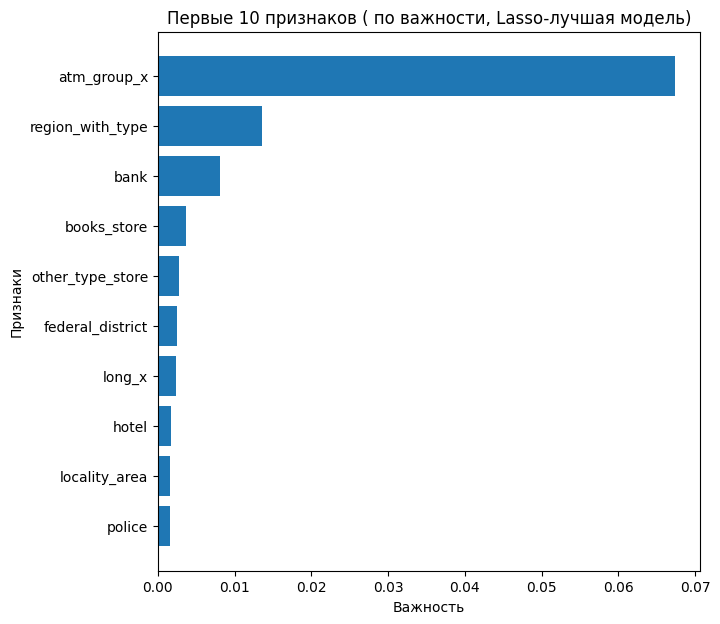

In [ ]:
weights_plot(weights, X_train_mean_sc.columns, 10, "Lasso-лучшая модель")

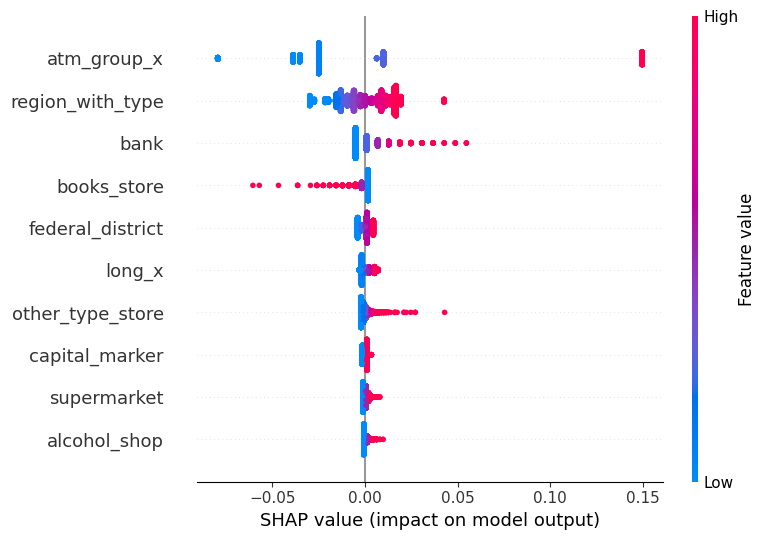

In [ ]:
shap_plot(best_lasso_mean, X_train_mean_sc, 10)

### Ridge

In [ ]:
a,b,c,d, weights = regression(Ridge(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0445
RMSE для теста равно 0.0470
r2 для трейна равно 0.7350219415
r2 для теста равно 0.6958107517


In [ ]:
a,b,c,d, weights = regression(Ridge(),X_train_mean_sc, X_test_mean_sc, y_train, y_test, X_train_mean_sc.columns)

MSE для трейна равно 0.0021
MSE для теста равно 0.0023
RMSE для трейна равно 0.0458
RMSE для теста равно 0.0478
r2 для трейна равно 0.7195125770
r2 для теста равно 0.6864673475


### Подбор параметров Ridge

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights,model = grid_search(Ridge(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.7122245316755335
{'alpha': 3.6}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0445
RMSE для теста равно 0.0470
r2 для трейна равно 0.7349621078
r2 для теста равно 0.6958911858


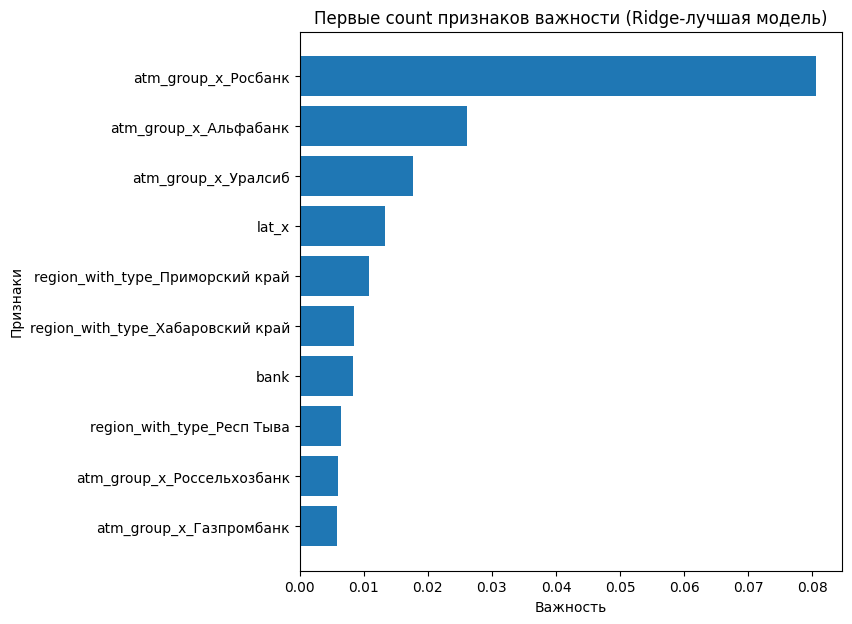

In [ ]:
weights_plot(weights, X_train_sc.columns, 10, "Ridge-лучшая модель")

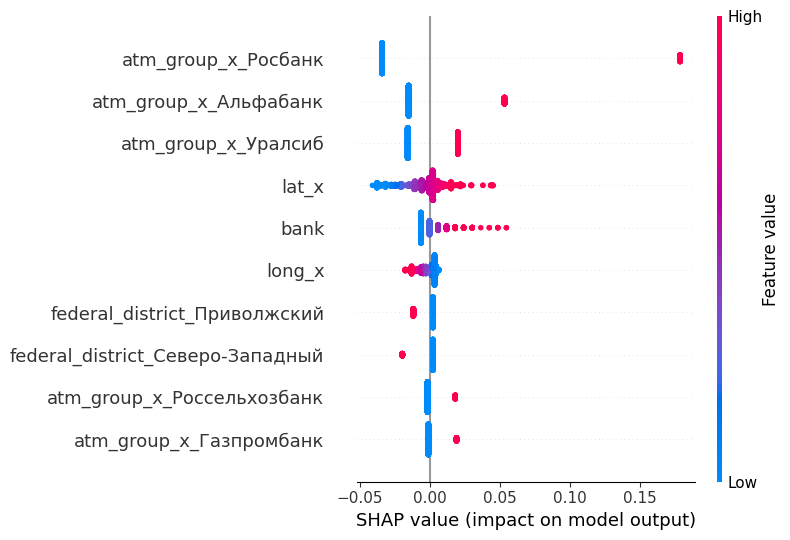

In [ ]:
X_train_sc_2000 = shap.sample(X_train_sc, 2000)
shap_plot(model, X_train_sc, 10)

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 10, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights,model = grid_search(Ridge(),params,cv,scoring,X_train_mean_sc, X_test_mean_sc, y_train, y_test)

{'alpha': 10.0}
MSE для трейна равно 0.0021
MSE для теста равно 0.0023
RMSE для трейна равно 0.0458
RMSE для теста равно 0.0478
r2 для трейна равно 0.7195087287
r2 для теста равно 0.6864866694


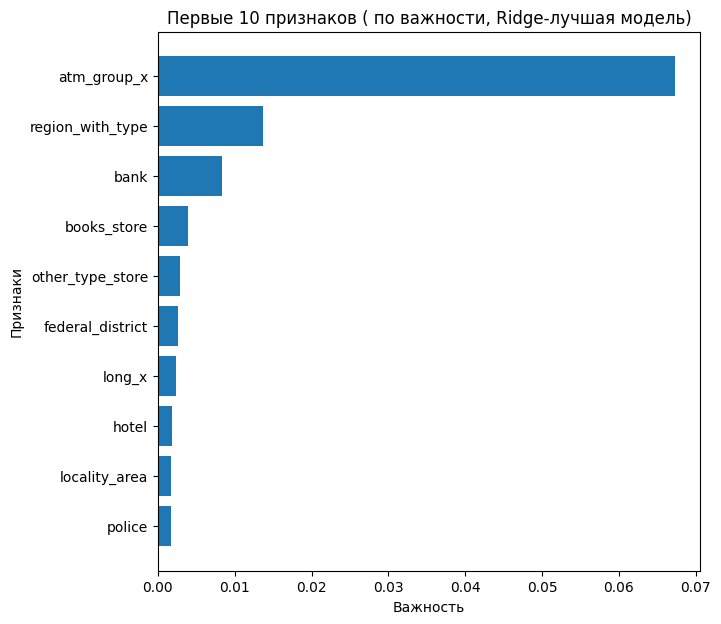

In [ ]:
weights_plot(weights, X_train_mean_sc.columns, 10, "Ridge-лучшая модель")

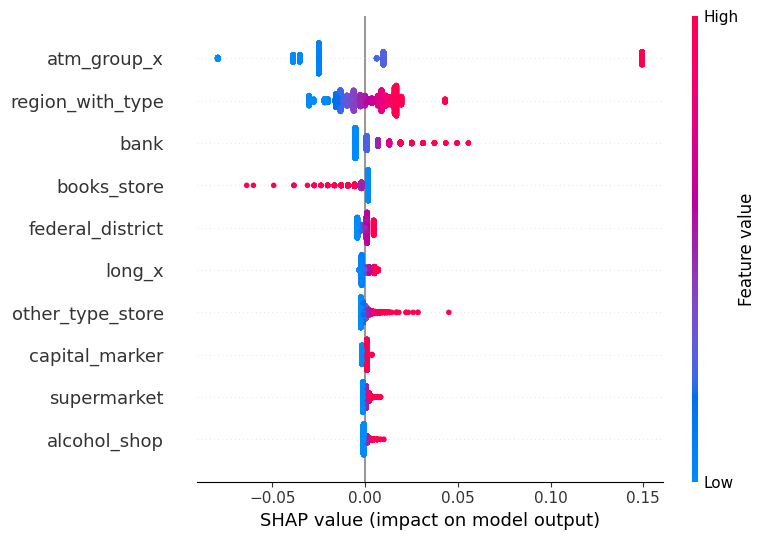

In [ ]:
shap_plot(model, X_train_mean_sc, 10)

Elastic_net

In [ ]:
a,b,c,d, weights = regression(ElasticNet(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


Подбор Elastic_net

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.001, 1, 100),
'l1_ratio': np.linspace(0.01, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights, model = grid_search(ElasticNet(max_iter=5000),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

#a,b,c,d, weights = elastic_net(params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

0.7133423392830495
{'alpha': 0.001, 'l1_ratio': 0.34}
MSE для трейна равно 0.0020
MSE для теста равно 0.0022
RMSE для трейна равно 0.0449
RMSE для теста равно 0.0471
r2 для трейна равно 0.7305915883
r2 для теста равно 0.6945017855


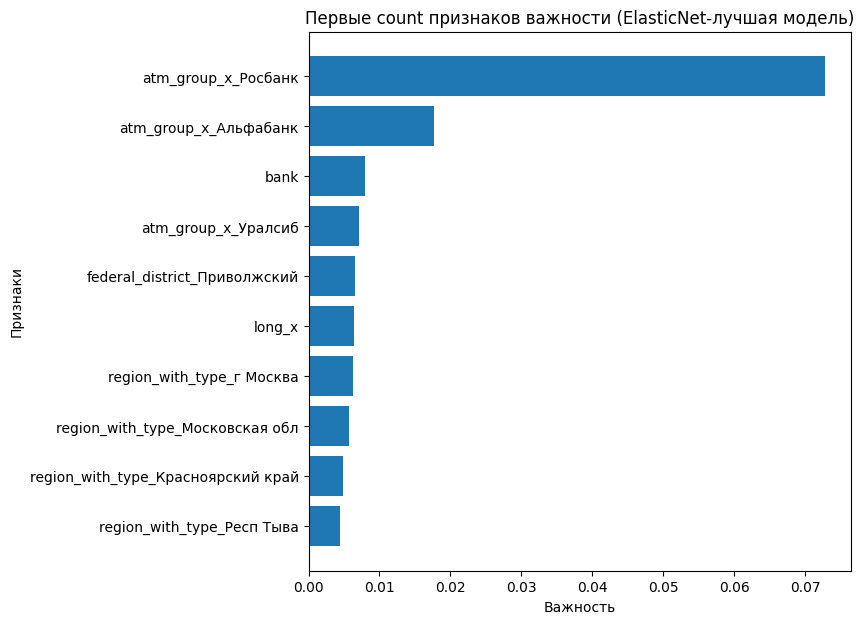

In [ ]:
weights_plot(weights, X_train_sc.columns, 10, "ElasticNet-лучшая модель")

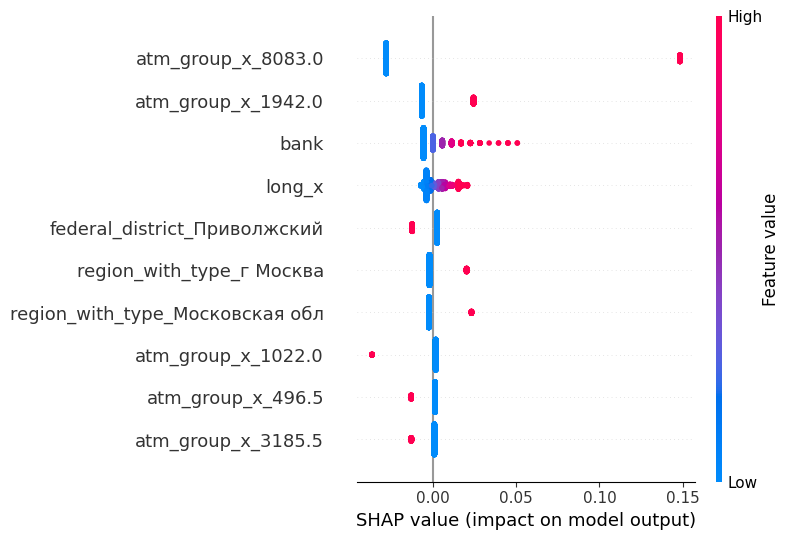

In [ ]:
X_train_sc_2000 = shap.sample(X_train_sc, 2000)
shap_plot(model, X_train_sc_2000, 10)

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.001, 1, 100),
'l1_ratio': np.linspace(0.01, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights, model = grid_search(ElasticNet(max_iter=5000),params,cv,scoring,X_train_mean_sc, X_test_mean_sc, y_train, y_test)

#a,b,c,d, weights = elastic_net(params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

{'alpha': 0.001, 'l1_ratio': 0.56}
MSE для трейна равно 0.0021
MSE для теста равно 0.0023
RMSE для трейна равно 0.0460
RMSE для теста равно 0.0477
r2 для трейна равно 0.7178539095
r2 для теста равно 0.6868617774


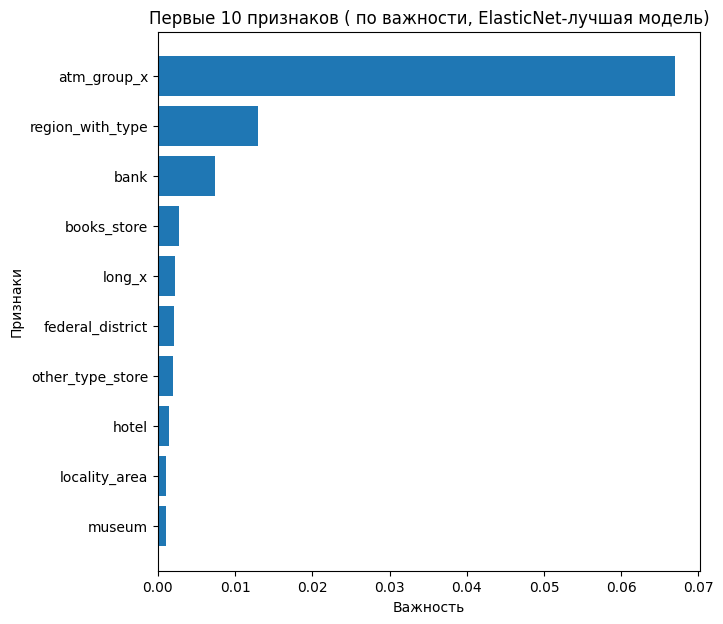

In [ ]:
weights_plot(weights, X_train_mean_sc.columns, 10, "ElasticNet-лучшая модель")

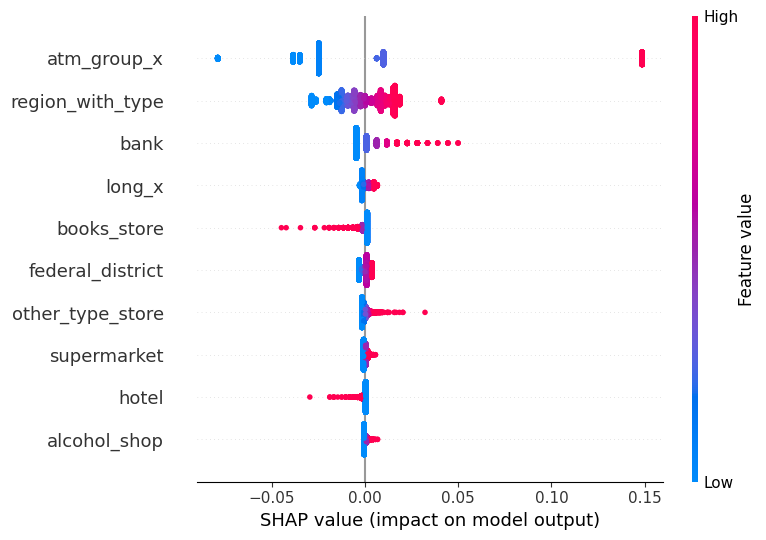

In [ ]:
shap_plot(model, X_train_mean_sc, 10)

### Стекинг

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier

models = [
    #('ridge', Ridge()),
    ('lasso', Lasso()),
     ('catboost', CatBoostRegressor(verbose=False)),
]

ensemble = StackingRegressor(
    estimators=models,
    verbose=True
)

ensemble.fit(X_train_sc, y_train)


r2_score(y_test, ensemble.predict(X_test_sc))

0.7324513784027542

In [ ]:
import pickle

# Сохранение объекта SimpleImputee в файл для дальнейшего использования в сервисе FastApi
with open("Model.pickle", "wb") as f:
    pickle.dump(ensemble, f)

In [ ]:
# Предсказываем значения для тренировочного и тестового набора данных
pred_train = ensemble.predict(X_train_sc)
pred_test = ensemble.predict(X_test_sc)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

MSE для трейна равно 0.0010
MSE для теста равно 0.0019
RMSE для трейна равно 0.0315
RMSE для теста равно 0.0437
r2 для трейна равно 0.8669535989
r2 для теста равно 0.7324513784


In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier

models = [
    #('ridge', Ridge()),
    ('lasso', Lasso()),
     ('catboost', CatBoostRegressor(verbose=False)),
]

ensemble = StackingRegressor(
    estimators=models,
    verbose=True
)

ensemble.fit(X_train_mean_sc, y_train)


r2_score(y_test, ensemble.predict(X_test_mean_sc))

0.7227816946662502

In [ ]:
# Предсказываем значения для тренировочного и тестового набора данных
pred_train = ensemble.predict(X_train_mean_sc)
pred_test = ensemble.predict(X_test_mean_sc)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

MSE для трейна равно 0.0010
MSE для теста равно 0.0020
RMSE для трейна равно 0.0309
RMSE для теста равно 0.0449
r2 для трейна равно 0.8724657942
r2 для теста равно 0.7227816947


### Стеккинг на лучших моделях (не дает улучшения)

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier

models = [
    #('ridge', Ridge()),
    ('lasso', best_lasso),
     ('catboost', best_catboost),
]

ensemble = StackingRegressor(
    estimators=models,
    verbose=True
)

ensemble.fit(X_train_sc, y_train)


r2_score(y_test, ensemble.predict(X_test_sc))

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.0805110	total: 9.54ms	remaining: 9.53s
1:	learn: 0.0756633	total: 22.9ms	remaining: 11.4s
2:	learn: 0.0717047	total: 34.1ms	remaining: 11.3s
3:	learn: 0.0680637	total: 39.9ms	remaining: 9.94s
4:	learn: 0.0651387	total: 46.7ms	remaining: 9.3s
5:	learn: 0.0625999	total: 56.4ms	remaining: 9.34s
6:	learn: 0.0602420	total: 66.9ms	remaining: 9.5s
7:	learn: 0.0583709	total: 76.6ms	remaining: 9.5s
8:	learn: 0.0567034	total: 86.2ms	remaining: 9.49s
9:	learn: 0.0551391	total: 92.3ms	remaining: 9.14s
10:	learn: 0.0538366	total: 101ms	remaining: 9.11s
11:	learn: 0.0528511	total: 110ms	remaining: 9.09s
12:	learn: 0.0519190	total: 122ms	remaining: 9.26s
13:	learn: 0.0511462	total: 130ms	remaining: 9.18s
14:	learn: 0.0505178	total: 137ms	remaining: 9.01s
15:	learn: 0.0499468	total: 146ms	remaining: 8.99s
16:	learn: 0.0494680	total: 155ms	remaining: 8.97s
17:	learn: 0.0490230	total: 164ms	remaining: 8.92s
18:	learn: 0.0486

0.7274735691566567

### LGBMRegressor

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4220 entries, 5259 to 895
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   atm_group                       4220 non-null   float64
 1   lat                             4220 non-null   float64
 2   long                            4220 non-null   float64
 3   city                            4220 non-null   object 
 4   federal_district                4220 non-null   object 
 5   region_with_type                4220 non-null   object 
 6   locality_area                   4220 non-null   float64
 7   locality_population             4220 non-null   float64
 8   sustenance                      4220 non-null   float64
 9   education                       4220 non-null   float64
 10  fuel                            4220 non-null   float64
 11  car_service                     4220 non-null   float64
 12  parking_space                   

In [ ]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([3, 4, 5])

In [ ]:
X_train['city'] = X_train['city'].astype('category')
X_test['city'] = X_test['city'].astype('category')

X_train['federal_district'] = X_train['federal_district'].astype('category')
X_test['federal_district'] = X_test['federal_district'].astype('category')

X_train['region_with_type'] = X_train['region_with_type'].astype('category')
X_test['region_with_type'] = X_test['region_with_type'].astype('category')


In [ ]:

model = LGBMRegressor(categorical_feature=categorical_features_indices)


model.fit(X_train, y_train)
# evaluate the model
# Предсказываем значения для тренировочного и тестового набора данных
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')


categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
categorical_feature in param dict is overridden.


[LightGBM] [Warning] categorical_feature is set=3,4,5, categorical_column=3,4,5 will be ignored. Current value: categorical_feature=3,4,5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 4220, number of used features: 43
[LightGBM] [Info] Start training from score 0.000063
MSE для трейна равно 0.0010
MSE для теста равно 0.0020
RMSE для трейна равно 0.0316
RMSE для теста равно 0.0451
r2 для трейна равно 0.8666004436
r2 для теста равно 0.7155550091


In [ ]:
X_train_sc.columns

Index(['lat_x', 'long_x', 'capital_marker', 'locality_area',
       'locality_population', 'sustenance', 'education', 'fuel', 'car_service',
       'parking_space',
       ...
       'region_with_type_Ульяновская обл', 'region_with_type_Хабаровский край',
       'region_with_type_Ханты-Мансийский Автономный округ - Югра',
       'region_with_type_Ханты-Мансийский Автономный округ - Югра АО',
       'region_with_type_Челябинская обл',
       'region_with_type_Чувашская Республика - Чувашия',
       'region_with_type_Чувашская республика - Чувашия',
       'region_with_type_Ярославская обл', 'region_with_type_г Москва',
       'region_with_type_г Санкт-Петербург'],
      dtype='object', length=138)

### LGBMRegressor - По умолчанию

In [ ]:
model = LGBMRegressor()
model.fit(X_train_sc, y_train)
# evaluate the model
# Предсказываем значения для тренировочного и тестового набора данных
pred_train = model.predict(X_train_sc)
pred_test = model.predict(X_test_sc)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1562
[LightGBM] [Info] Number of data points in the train set: 4108, number of used features: 111
[LightGBM] [Info] Start training from score 0.001546
MSE для трейна равно 0.0011
MSE для теста равно 0.0021
RMSE для трейна равно 0.0325
RMSE для теста равно 0.0453
r2 для трейна равно 0.8585116790
r2 для теста равно 0.7178597415


### LGBMRegressor - Подбор по сетке (не изменило метрики)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': list(range(31, 40)),
    "max_depth": [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'colsample_bytree': [0.8, 1],
    'subsample_for_bin': [150000,200000]
}


param_grid = {
    'num_leaves': list(range(35, 50)),
    "max_depth": [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'colsample_bytree': [0.8, 1],
    'subsample_for_bin': [150000,200000]
}


lgbm = LGBMRegressor()  # Instantiate the LGBMRegressor

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_sc, y_train)

# Obtain the best parameters and instantiate the model with the best parameters
best_params = grid_search.best_params_
lgbm_tuned = LGBMRegressor(**best_params)

# Train the tuned LGBMRegressor model on the training data
lgbm_tuned.fit(X_train_sc, y_train)

y_test_pred = lgbm_tuned.predict(X_test_sc)  # Predicting X_test to find the solution
score = round(r2_score(y_test, y_test_pred), 6)  # Find the R2 score of y_test and predictions

print(score)



Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 3287, number of used features: 105
[LightGBM] [Info] Start training from score 0.001370
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 3287, number of used features: 107
[LightGBM] [I

In [ ]:

# Предсказываем значения для тренировочного и тестового набора данных
pred_train = lgbm_tuned.predict(X_train_sc)
pred_test = model.predict(X_test_sc)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

MSE для трейна равно 0.0010
MSE для теста равно 0.0021
RMSE для трейна равно 0.0315
RMSE для теста равно 0.0453
r2 для трейна равно 0.8670598764
r2 для теста равно 0.7178597415


### ЧТо-то странное на фолдах

In [ ]:
model = LGBMRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_sc, y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
print('R2: %.6f (%.6f)' % (mean(n_scores), std(n_scores)))

R2: 0.736274 (0.027388)


In [ ]:
params = model.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Важность признаков

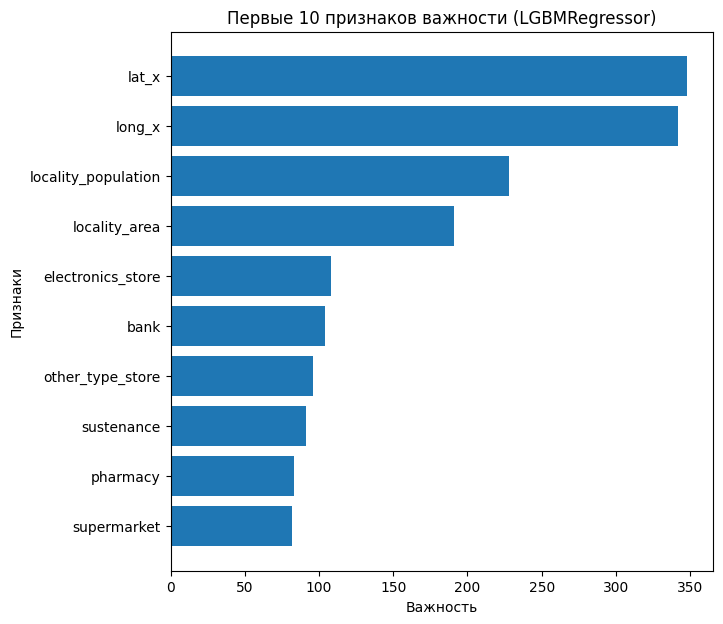

In [ ]:
weights_plot(model.feature_importances_, X_train_sc.columns, 10, 'LGBMRegressor')

100%|===================| 4094/4108 [00:22<00:00]       

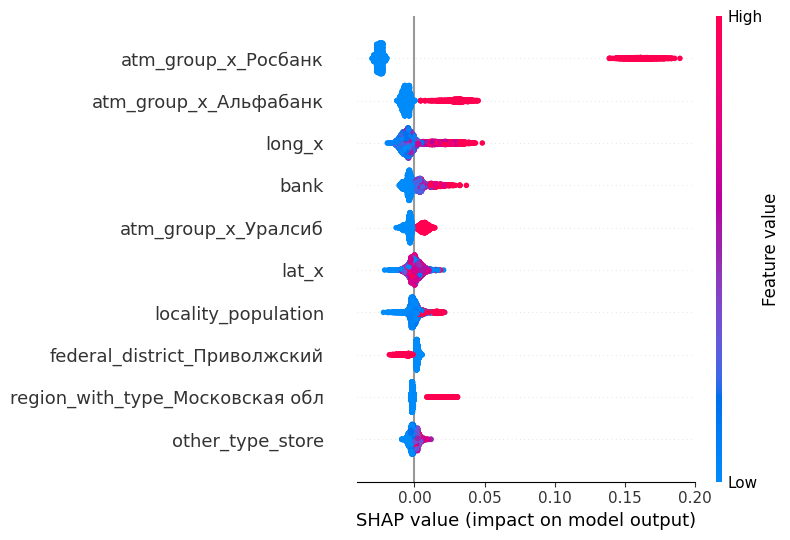

In [ ]:
shap_plot(model, X_train_sc, 10)

Полиномиальные признаки

In [ ]:
# Фильтруем поля, не имеющие тип object
non_object_fields = X_train_enc.select_dtypes(exclude='object').columns
X_train_filtered = X_train_enc[non_object_fields]

X_train_filtered.head()

,lat_x,long_x,capital_marker,locality_area,locality_population,sustenance,education,fuel,car_service,parking_space,...,region_with_type_Ульяновская обл,region_with_type_Хабаровский край,region_with_type_Ханты-Мансийский Автономный округ - Югра,region_with_type_Ханты-Мансийский Автономный округ - Югра АО,region_with_type_Челябинская обл,region_with_type_Чувашская Республика - Чувашия,region_with_type_Чувашская республика - Чувашия,region_with_type_Ярославская обл,region_with_type_г Москва,region_with_type_г Санкт-Петербург
0,54.984114,82.891603,2.0,480.886137,1625631.0,8.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,55.806894,37.635593,0.0,2562.617022,12678079.0,7.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,59.092104,37.904045,0.0,135.301998,314834.0,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,54.022683,38.259044,1.0,105.148100,122306.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,54.923305,73.473216,2.0,0.000000,1154507.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train_sc[non_object_fields])


Добавление полиномиальных признаков

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.fit_transform(X_test_sc)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_mean_poly = poly.fit_transform(X_train_mean_sc)
X_test_mean_poly = poly.fit_transform(X_test_mean_sc)

In [ ]:
a,b,c,d, weights = regression(LinearRegression(),X_train_poly, X_test_poly, y_train, y_test, X_train_enc.columns)

MSE для трейна равно 0.0002
MSE для теста равно 156942379161556384.0000
RMSE для трейна равно 0.0130
RMSE для теста равно 396159537.5118
r2 для трейна равно 0.9773853441
r2 для теста равно -21577323867006095360.0000000000


In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier

models = [
    #('ridge', Ridge()),
    ('lasso', Lasso()),
     ('catboost', CatBoostRegressor(verbose=False)),
]

meta_model = ElasticNet()  # CatBoostRegressor(verbose=True)

ensemble = StackingRegressor(
    estimators=models,
    verbose=True
)

ensemble.fit(X_train_poly, y_train)


r2_score(y_test, ensemble.predict(X_test_poly))

KeyboardInterrupt: 

Lasso (полиномиальные)



In [ ]:
a,b,c,d, weights = regression(Lasso(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


Lasso (полиномиальные) - подбор

In [ ]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d, weights = grid_search(Lasso(max_iter=1000),params,cv,scoring,X_train_poly,X_test_poly, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.280e-01, tolerance: 2.424e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-01, tolerance: 2.478e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.627e-01, tolerance: 2.483e

0.6841390130806186
{'alpha': 0.010199999999999999}
MSE для трейна равно 0.0023
MSE для теста равно 0.0024
RMSE для трейна равно 0.0478
RMSE для теста равно 0.0494
r2 для трейна равно 0.6946126815
r2 для теста равно 0.6649955422


In [ ]:
params = {'alpha' : np.linspace(0.0001, 1, 10)}
cv = 5
scoring = 'r2'
a,b,c,d, weights, model_mean = grid_search(Lasso(max_iter=5000),params,cv,scoring,X_train_mean_poly,X_test_mean_poly, y_train, y_test)

{'alpha': 0.0001}
MSE для трейна равно 0.0015
MSE для теста равно 0.0027
RMSE для трейна равно 0.0386
RMSE для теста равно 0.0519
r2 для трейна равно 0.8007466521
r2 для теста равно 0.6299877615


Ridge (полиномиальные)

In [ ]:
a,b,c,d, weights = regression(Ridge(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0003
MSE для теста равно 0.0452
RMSE для трейна равно 0.0170
RMSE для теста равно 0.2126
r2 для трейна равно 0.9612191531
r2 для теста равно -5.2119788551


Ridge на сетке (долго считает)

In [ ]:
# задаем словарь параметр: список перебираемых значений
params = {'alpha' : np.linspace(0.1, 100, 10)}
params = {'alpha' : np.linspace(0.1, 5000, 20)} # 9 vby
cv = 5
scoring="r2"

a,b,c,d, weights = grid_search(Ridge(),params,cv,scoring,X_train_poly, X_test_poly, y_train, y_test)

0.6447068675931142
{'alpha': 2631.6263157894737}
MSE для трейна равно 0.0011
MSE для теста равно 0.0026
RMSE для трейна равно 0.0337
RMSE для теста равно 0.0512
r2 для трейна равно 0.8481817808
r2 для теста равно 0.6393099100


Elastic_net

In [ ]:
a,b,c,d, weights = regression(ElasticNet(),X_train_poly, X_test_poly, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0075
MSE для теста равно 0.0073
RMSE для трейна равно 0.0865
RMSE для теста равно 0.0853
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0012160350


In [ ]:
params = {'alpha' : np.linspace(0.001, 1, 10),
'l1_ratio': np.linspace(0.01, 1, 10)}

params = {'alpha' : np.linspace(0.001, 1, 10), 'l1_ratio': np.linspace(0.01, 1, 10)} #26 мин
cv = 5
scoring="r2"

grid_search(ElasticNet(),params,cv,scoring,X_train_poly,X_test_poly, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.702e-01, tolerance: 2.424e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e-01, tolerance: 2.478e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.344e-01, tolerance: 2.483e

0.7051744412962077
{'alpha': 0.112, 'l1_ratio': 0.01}
MSE для трейна равно 0.0017
MSE для теста равно 0.0021
RMSE для трейна равно 0.0413
RMSE для теста равно 0.0460
r2 для трейна равно 0.7717633116
r2 для теста равно 0.7085335160


(0.00170836332387802,
 0.00211997760824385,
 0.7717633115949686,
 0.7085335160059588,
 array([0.        , 0.        , 0.        , ..., 0.00145687, 0.        ,
        0.00011295]))

##Показ на карте

In [ ]:
!pip install gmaps
!pip install widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
  Created wheel for gmaps: filename=gmaps-0.9.0-py2.py3-none-any.whl size=2076086 sha256=f5282bfa89d7a2c9df2f3515a0da34e6d043e199be1f9e9bee45248f7c87734c
  Stored in directory: /root/.cache/pip/wheels/b3/c2/dc/48b3ef16c2184dae51a003f17eb5d065bbbf1af3437d9f14e3
Successfully built gmaps


Получение списка объектов с непустыми координатами

In [ ]:
df_not_empty_location = df[(~df['lat'].isna()) & (~df['long'].isna())][['lat', 'long', 'target']]
list_coords = df_not_empty_location.values.tolist()
len(list_coords)

6260

Значение целевой переменной

In [ ]:
df['target'].describe()

count    6261.000000
mean        0.000715
std         0.085852
min        -0.145001
25%        -0.061176
50%        -0.015573
75%         0.040149
max         0.218608
Name: target, dtype: float64

In [ ]:
level1 =  quantile(0.25)
level2 = df['target'].quantile(0.5)
level3 = df['target'].quantile(0.75)

Отрисовка положения банкоматов на карте с учетом значения целевой переменной с помощью Folium

In [ ]:
import folium
location=[55.739696,37.615407]
map = folium.Map(location=location, zoom_start = 3)
 # Создание кругового маркера

folium.CircleMarker(
      location=location,
      radius=5,  # радиус в метрах
      color='red',
      fill=True,
      fill_opacity=0.5
  ).add_to(map)
folium.CircleMarker(
      location=location,
      radius=150,  # радиус в метрах
      color='red',
      fill=True,
      fill_opacity=0.2
  ).add_to(map)

map

In [ ]:
import folium

map = folium.Map(location=[46.940995,142.738319], zoom_start = 3)

for coord in list_coords:
  if coord[2] < level1:
    color = 'yellow'
  elif coord[2] <level2:
    color = 'purple'
  elif coord[2] <level3:
    color = 'blue'
  else:
    color = 'red'
  # Создание кругового маркера
  folium.CircleMarker(
      location=[coord[0],coord[1]],
      radius=5,  # радиус в метрах
      color=color,
      fill=True,
      fill_opacity=0.5
  ).add_to(map)

 # Создание кругового маркера
  folium.CircleMarker(
      location=[55.739696,37.615407],
      radius=150,  # радиус в метрах
      color=color,
      fill=True,
      fill_opacity=0.2
  ).add_to(map)
map

NameError: name 'list_coords' is not defined

## Catboost - модель с полем city

### Разделение на train/test

In [ ]:
Y = df['target_x']
X = df.drop(columns=["target_x"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([0, 3, 4])

### Catboost

In [ ]:
a,b,c,d,model = cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices)

0:	learn: 0.0508368	test: 0.0503643	best: 0.0503643 (0)	total: 4.24ms	remaining: 4.24ms
1:	learn: 0.0495946	test: 0.0494115	best: 0.0494115 (1)	total: 8.4ms	remaining: 0us

bestTest = 0.04941150342
bestIteration = 1

MSE для трейна равно 0.0024
MSE для теста равно 0.0024
RMSE для трейна равно 0.0492
RMSE для теста равно 0.0494
r2 для трейна равно 0.6757609518
r2 для теста равно 0.6583729294


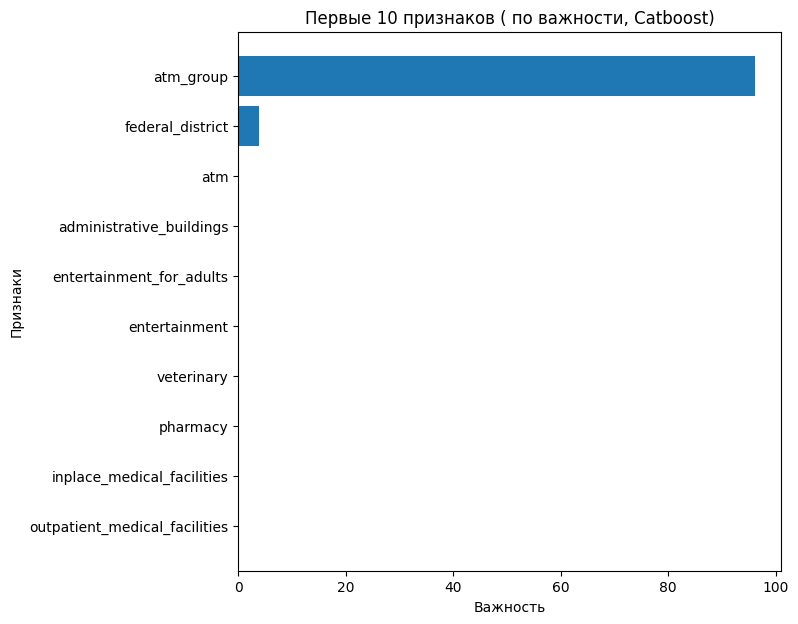

In [ ]:
weights_plot(model.feature_importances_, X_train.columns, 10, 'Catboost')

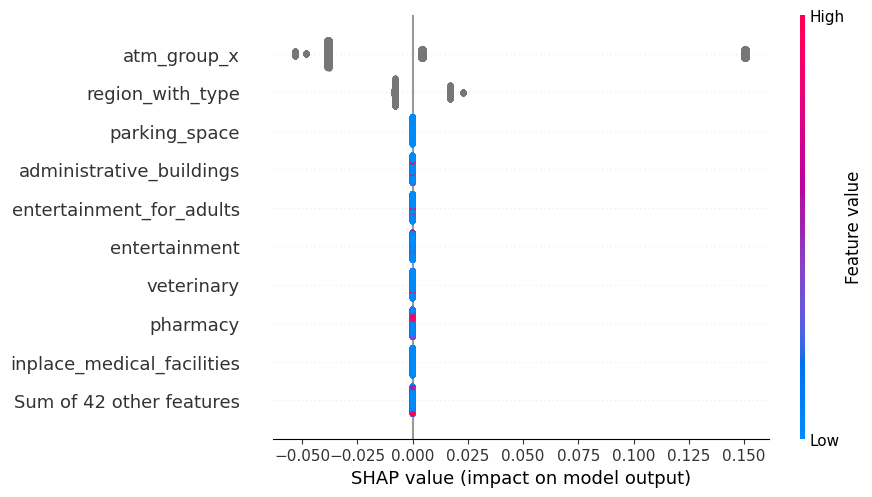

In [ ]:
#explainer = shap.Explainer(model, X_train_sc)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

### Catboost на сетке

In [ ]:
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

iter = 2
loss = 'RMSE'
cv = 5

a,b,c,d,model = grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

#cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)

0:	learn: 0.0845542	total: 3.19ms	remaining: 3.19ms
1:	learn: 0.0830606	total: 6.07ms	remaining: 0us
0:	learn: 0.0843352	total: 2.41ms	remaining: 2.41ms
1:	learn: 0.0828269	total: 5.08ms	remaining: 0us
0:	learn: 0.0849507	total: 2.82ms	remaining: 2.82ms
1:	learn: 0.0834052	total: 5.49ms	remaining: 0us
0:	learn: 0.0853512	total: 2.48ms	remaining: 2.48ms
1:	learn: 0.0837388	total: 5.14ms	remaining: 0us
0:	learn: 0.0847465	total: 2.49ms	remaining: 2.49ms
1:	learn: 0.0831518	total: 4.79ms	remaining: 0us
0:	learn: 0.0807506	total: 2.73ms	remaining: 2.73ms
1:	learn: 0.0763220	total: 5.43ms	remaining: 0us
0:	learn: 0.0807238	total: 2.16ms	remaining: 2.16ms
1:	learn: 0.0762604	total: 5.01ms	remaining: 0us
0:	learn: 0.0811061	total: 2.29ms	remaining: 2.29ms
1:	learn: 0.0765245	total: 4.62ms	remaining: 0us
0:	learn: 0.0817418	total: 3.49ms	remaining: 3.49ms
1:	learn: 0.0769063	total: 6.17ms	remaining: 0us
0:	learn: 0.0811676	total: 2.55ms	remaining: 2.55ms
1:	learn: 0.0763980	total: 5.42ms	remai

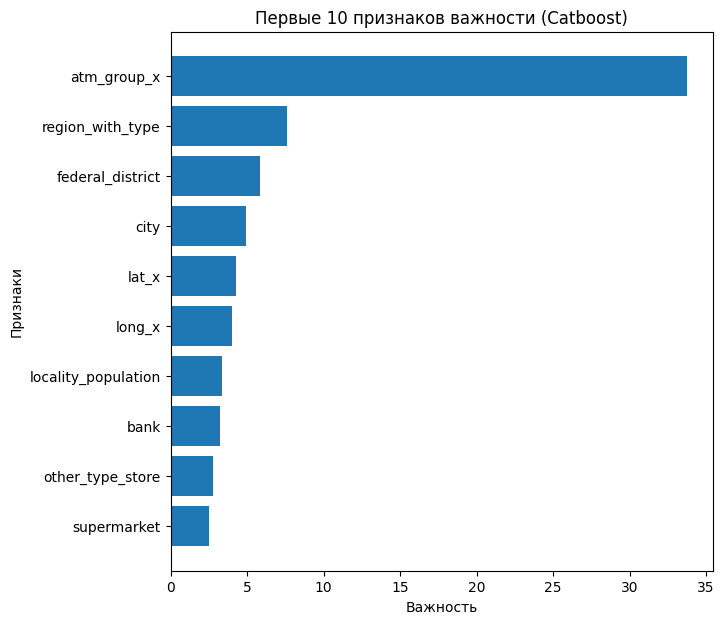

In [ ]:
weights_plot(model.feature_importances_, X_train.columns, 10, 'Catboost')

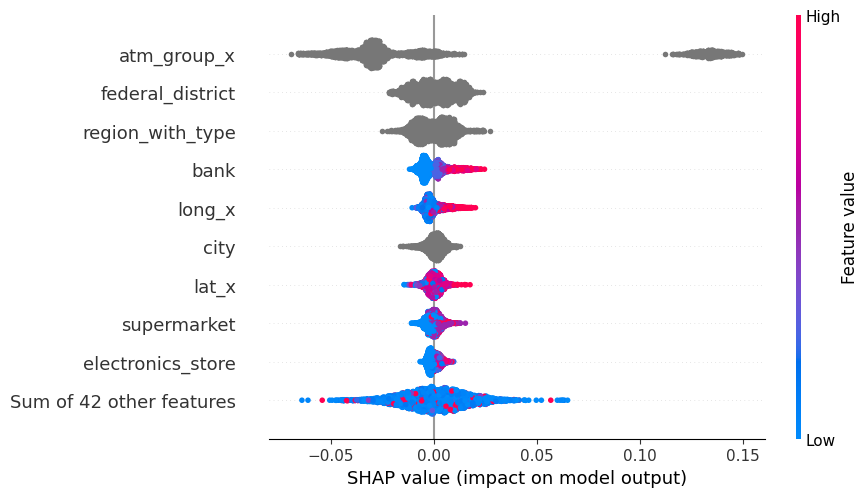

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

### Подбор с помощью Optuna

In [ ]:
# Определение категориальных признаков
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([0, 3, 4])

In [ ]:
X_train.columns

Index(['atm_group', 'lat', 'long', 'federal_district', 'region_with_type',
       'locality_area', 'locality_population', 'sustenance', 'education',
       'fuel', 'car_service', 'parking_space', 'atm', 'bank',
       'bureau_de_change', 'outpatient_medical_facilities',
       'inplace_medical_facilities', 'pharmacy', 'veterinary', 'entertainment',
       'entertainment_for_adults', 'administrative_buildings', 'police',
       'fire_station', 'post_office', 'grave_yard', 'marketplace', 'monastery',
       'place_of_worship', 'public_transport_stop_position', 'alcohol_shop',
       'food_shop', 'supermarket', 'mall', 'wholesale', 'clothing_shop',
       'discount_store', 'beauty_store', 'hardware_store', 'interior_store',
       'electronics_store', 'sport_store', 'auto_moto_store',
       'car_parts_store', 'hobbies_store', 'books_store', 'hotel', 'museum'],
      dtype='object')

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostRegressor
def objective_catboost(trial):
    depth = trial.suggest_int("depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    iterations = trial.suggest_int("iterations", 10, 1000)

    score = cross_val_score(CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, cat_features=categorical_features_indices),
                            X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2024-01-14 22:29:23,610] A new study created in memory with name: no-name-5058d8f0-2b01-4f7b-9b61-d85ac5265dc1
[I 2024-01-14 22:29:47,045] Trial 0 finished with value: 0.3468119640319296 and parameters: {'depth': 7, 'learning_rate': 0.00047846127423286234, 'iterations': 825}. Best is trial 0 with value: 0.3468119640319296.
[I 2024-01-14 22:29:54,992] Trial 1 finished with value: 0.7264031067458337 and parameters: {'depth': 4, 'learning_rate': 0.06276300321227443, 'iterations': 635}. Best is trial 1 with value: 0.7264031067458337.
[I 2024-01-14 22:29:58,339] Trial 2 finished with value: 0.010400289874249272 and parameters: {'depth': 2, 'learning_rate': 1.8498608947651616e-05, 'iterations': 650}. Best is trial 1 with value: 0.7264031067458337.
[I 2024-01-14 22:30:19,619] Trial 3 finished with value: 0.2100066047612812 and parameters: {'depth': 7, 'learning_rate': 0.00026596763595723, 'iterations': 772}. Best is trial 1 with value: 0.7264031067458337.
[I 2024-01-14 22:30:34,139] Trial 

In [ ]:
# Создаем модель с лучшими параметрами
model = CatBoostRegressor(**study.best_params)

#model = CatBoostRegressor(study.best_params)
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Предсказываем значения для тренировочного и тестового набора данных
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку (MSE) для тренировочного и тестового набора данных
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

# Вычисляем корень из среднеквадратичной ошибки (RMSE) для тренировочного и тестового набора данных
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Вычисляем коэффициент детерминации (r2_score) для тренировочного и тестового набора данных
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

# Выводим значения MSE, RMSE и r2 для тренировочного и тестового набора данных
print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

0:	learn: 0.0824689	total: 46.9ms	remaining: 13.5s
1:	learn: 0.0788097	total: 72.3ms	remaining: 10.4s
2:	learn: 0.0755001	total: 113ms	remaining: 10.8s
3:	learn: 0.0725138	total: 142ms	remaining: 10.1s
4:	learn: 0.0698346	total: 170ms	remaining: 9.67s
5:	learn: 0.0673831	total: 194ms	remaining: 9.14s
6:	learn: 0.0653408	total: 220ms	remaining: 8.87s
7:	learn: 0.0634457	total: 247ms	remaining: 8.69s
8:	learn: 0.0617290	total: 272ms	remaining: 8.46s
9:	learn: 0.0601722	total: 300ms	remaining: 8.37s
10:	learn: 0.0589193	total: 311ms	remaining: 7.86s
11:	learn: 0.0579258	total: 338ms	remaining: 7.81s
12:	learn: 0.0571529	total: 361ms	remaining: 7.67s
13:	learn: 0.0560767	total: 386ms	remaining: 7.58s
14:	learn: 0.0550783	total: 410ms	remaining: 7.49s
15:	learn: 0.0541799	total: 436ms	remaining: 7.44s
16:	learn: 0.0536079	total: 460ms	remaining: 7.37s
17:	learn: 0.0527860	total: 479ms	remaining: 7.21s
18:	learn: 0.0520474	total: 503ms	remaining: 7.14s
19:	learn: 0.0515699	total: 530ms	remai

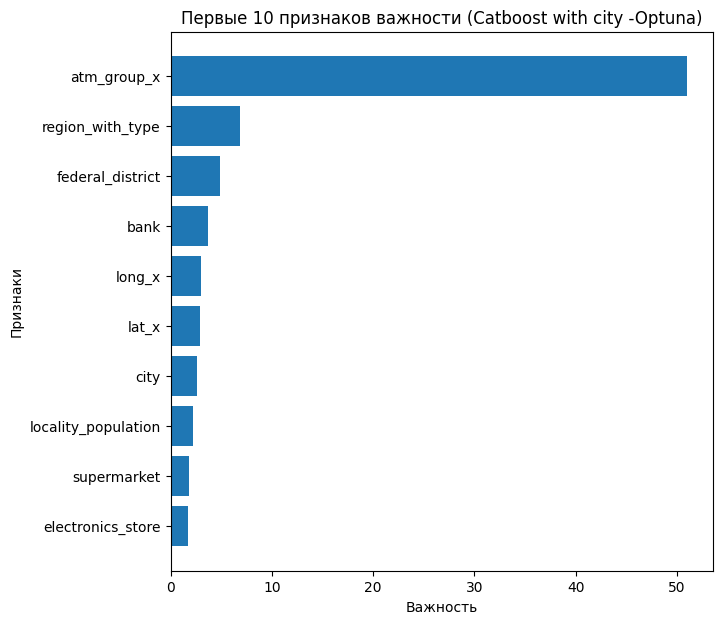

In [ ]:
weights_plot(model.feature_importances_, X_train.columns, 10, 'Catboost with city -Optuna')


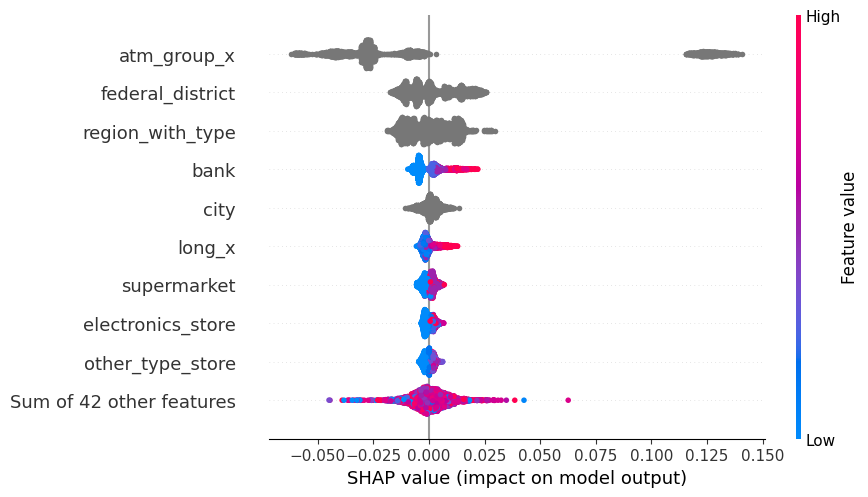

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)